# Env prepare

In [ ]:
# install env
!pip install yfinance --upgrade --no-cache-dir
!pip install torch
!pip install numpy
!pip install seaborn
!pip install sklearn

In [1]:
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import random
import pandas as pd
import seaborn as sns

# Data processing

In [3]:
tickerStrings = ["SPY", "AAPL", "TSLA", "AMZN", "META"]
def stocks_data(tickerStrings):
    for ticker in tickerStrings:
        # df_temp = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/ticker/ticker_{ticker}.csv', index_col='Date',parse_dates=True)
        df_temp = pd.read_csv(f'./ticker/ticker_{ticker}.csv', index_col='Date',parse_dates=True)

    return df_temp
df = stocks_data(tickerStrings) # META

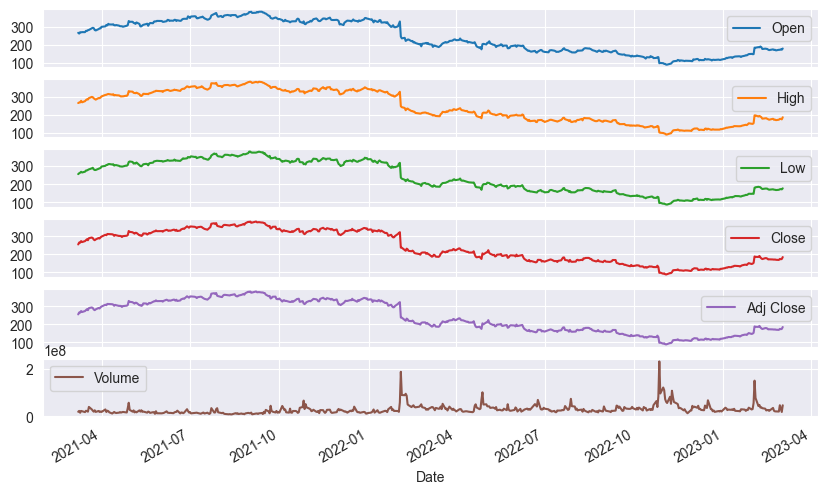

In [6]:
sns.set_style("darkgrid")
df.plot(figsize=(10, 6), subplots=True);

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 502 entries, 2021-03-08 to 2023-03-03
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       502 non-null    float64
 1   High       502 non-null    float64
 2   Low        502 non-null    float64
 3   Close      502 non-null    float64
 4   Adj Close  502 non-null    float64
 5   Volume     502 non-null    int64  
 6   ticker     502 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 31.4+ KB


In [13]:
look_back = 30
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    
    train_set_size = data.shape[0] - (test_set_size);
    print(test_set_size,train_set_size)
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
scaler = MinMaxScaler(feature_range=(-1, 1))
minmax = scaler.fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)

x_train, y_train, x_test, y_test = load_data(df_log,look_back = look_back)
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

94 378
x_train.shape =  torch.Size([378, 29, 1])
y_train.shape =  torch.Size([378, 1])
x_test.shape =  torch.Size([94, 29, 1])
y_test.shape =  torch.Size([94, 1])


# Training
there are two type of problem
-   **Binary Classification Problem**: predict positive (**Up**) or negative (**Down**) return respect to the previous day.
-   **Regression Problem**: predict the **exact return**; more useful to feed an hypothetical trading algorithm.

## Split train and test

I will cut the dataset to train and test datasets,

1. Train dataset derived from starting timestamp until last 30 days
2. Test dataset derived from last 30 days until end of the dataset

So we will let the model do forecasting based on last 30 days, and we will going to repeat the experiment for 10 times. You can increase it locally if you want, and tuning parameters will help you by a lot.


In [23]:
# Build model
#####################
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, requires_grad=False)

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, requires_grad=False)

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0, c0))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [24]:
# Train model
#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()


    

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.03254384547472
Epoch  20 MSE:  0.020184673368930817
Epoch  30 MSE:  0.017248427495360374
Epoch  40 MSE:  0.011176916770637035
Epoch  50 MSE:  0.008475112728774548
Epoch  60 MSE:  0.007040493190288544
Epoch  70 MSE:  0.006209800951182842
Epoch  80 MSE:  0.005746503826230764
Epoch  90 MSE:  0.005473071243613958


In [25]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 10.65 RMSE
Test Score: 12.61 RMSE


C:\Users\Leheng\AppData\Local\Temp\ipykernel_17980\973254333.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


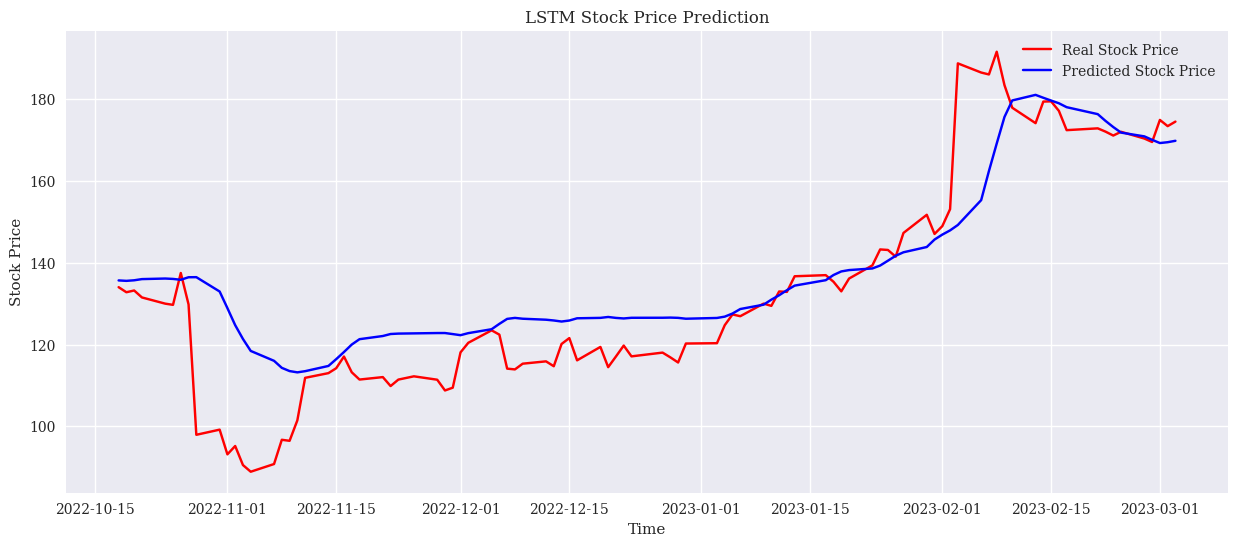

In [26]:
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df[len(df)-len(y_test):].index, y_test, color = 'red', label = 'Real Stock Price')
axes.plot(df[len(df)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('LSTM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig('pred.png')
plt.show()

In [27]:
len(y_test),len(df)-len(y_test)

(94, 408)

In [13]:
df[len(df)-len(y_test):].index

DatetimeIndex(['2022-12-29', '2022-12-30', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-09', '2023-01-10',
               '2023-01-11', '2023-01-12', '2023-01-13', '2023-01-17',
               '2023-01-18', '2023-01-19', '2023-01-20', '2023-01-23',
               '2023-01-24', '2023-01-25', '2023-01-26', '2023-01-27',
               '2023-01-30', '2023-01-31', '2023-02-01', '2023-02-02',
               '2023-02-03', '2023-02-06', '2023-02-07', '2023-02-08',
               '2023-02-09', '2023-02-10', '2023-02-13', '2023-02-14',
               '2023-02-15', '2023-02-16', '2023-02-17', '2023-02-21',
               '2023-02-22', '2023-02-23', '2023-02-24', '2023-02-27',
               '2023-02-28', '2023-03-01', '2023-03-02', '2023-03-03'],
              dtype='datetime64[ns]', name='Date', freq=None)